# ANOVA

In [1]:
!pip install pingouin
import pandas as pd
import scipy.stats
import numpy as np
import pingouin as pg
import seaborn as sns
from matplotlib import pyplot as plt

## Part1: Data preparation

In [2]:
# Read the data from the file
# Data from https://www.kaggle.com/benroshan/factors-affecting-campus-placement?select=Placement_Data_Full_Class.csv
import requests
excel_url = 'https://docs.google.com/spreadsheets/d/1e7Tax_x1dKm181wpCk8cLmN5gP_M9ZTGngXQg0cGe14/export?format=xlsx'
response = requests.get(excel_url)
response.raise_for_status()  # Ensure the request was successful
with open('sheet.xlsx', 'wb') as file:
    file.write(response.content)
df = pd.read_excel('sheet.xlsx')

In [3]:
# Check the first few lines to see the column names and type of content
# On campus placement Jain University Bangalore
# ssc_p: secondary education percentage
# ssc_b: board of education, secondary
# hsc_p, hsb_b: higher secondary education
# hsc_s: higher secondary specialization
# degree_p: percentage
# degree_t: field undergraduate
# workex: Work experience
# salary in rupees (1 euro = 100 rupees)
df.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [4]:
# Size of the dataframe
len(df)

215

In [5]:
# Remove rows with empty values
df = df.replace(r'^\s*$', float('NaN'), regex = True)
df.dropna(inplace = True)
len(df)

148

In [6]:
# Let us check the types of the different columns
df.dtypes

sl_no               int64
gender             object
ssc_p             float64
ssc_b              object
hsc_p             float64
hsc_b              object
hsc_s              object
degree_p          float64
degree_t           object
workex             object
etest_p           float64
specialisation     object
mba_p             float64
status             object
salary            float64
dtype: object

In [7]:
# Let us adapt the dataframe (remove IDs, and make sure that columns have the right type)
del df['sl_no']
df['gender'] = df['gender'].astype('category')
df['ssc_b'] = df['ssc_b'].astype('category')
df['hsc_b'] = df['hsc_b'].astype('category')
df['hsc_s'] = df['hsc_s'].astype('category')
df['degree_t'] = df['degree_t'].astype('category')
df['workex'] = df['workex'].astype('category')
df['status'] = df['status'].astype('category')

## Part 2: Data exploration

In [8]:
# Lets see the summary of the numerical columns
# A euro is approximately 82 rupees
df.describe()

,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary
count,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000
mean,71.721486,69.926554,68.740541,73.238041,62.579392,288655.405405
std,8.715445,9.329268,6.518087,13.729333,5.884583,93457.452420
min,49.000000,50.830000,56.000000,50.000000,52.380000,200000.000000
25%,65.000000,63.000000,65.000000,60.000000,57.772500,240000.000000
50%,72.500000,68.000000,68.000000,72.000000,62.245000,265000.000000
75%,78.125000,75.250000,72.422500,85.000000,66.760000,300000.000000
max,89.400000,97.700000,91.000000,98.000000,77.890000,940000.000000


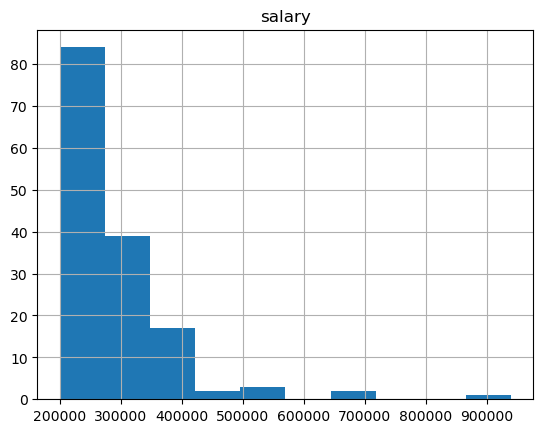

In [9]:
# Histogram of charges
df.hist(column="salary");

C:\Users\plosa\AppData\Local\Temp\ipykernel_18084\3073655840.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['salary'].hist(by=df['gender'])


array([<Axes: title={'center': 'F'}>, <Axes: title={'center': 'M'}>],
      dtype=object)

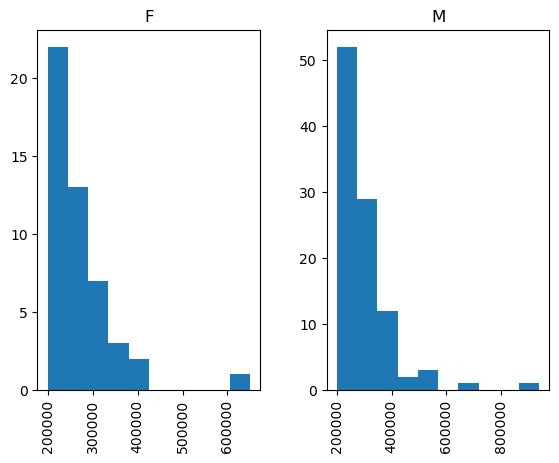

In [29]:
# Check if there are differences by sex
df['salary'].hist(by=df['gender'])

In [11]:
# Let us explore the correlation matrix
corrMatrix = df.corr(numeric_only=True)
print (corrMatrix)

             ssc_p     hsc_p  degree_p   etest_p     mba_p    salary
ssc_p     1.000000  0.293416  0.380657  0.317892  0.430560  0.035330
hsc_p     0.293416  1.000000  0.221307  0.284672  0.329983  0.076819
degree_p  0.380657  0.221307  1.000000  0.217683  0.494093 -0.019272
etest_p   0.317892  0.284672  0.217683  1.000000  0.284143  0.178307
mba_p     0.430560  0.329983  0.494093  0.284143  1.000000  0.175013
salary    0.035330  0.076819 -0.019272  0.178307  0.175013  1.000000


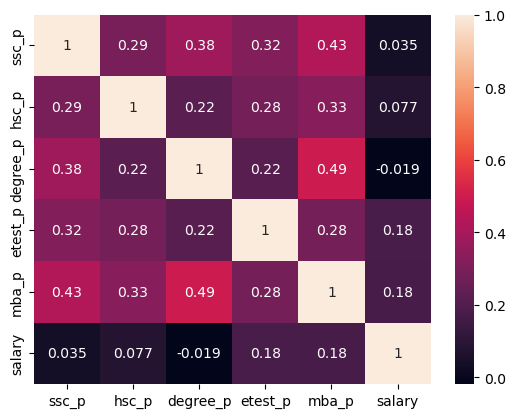

In [12]:
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [13]:
from termcolor import colored
def explore(df, yname, xname):
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    sns.boxplot(x=xname, y=yname, data=df, ax=ax)
    sns.swarmplot(x=xname, y=yname, data=df, color='black', alpha = 0.5, ax=ax);

    print('Checking normality with Shapiro-Wilk')
    print(pg.normality(data=df, dv=yname, group=xname))

    print(' ')
    print('Checking homocedasticity')
    print(pg.homoscedasticity(data=df, dv=yname, group=xname, method='levene'))

    print(' ')
    print('Checking dependence of y on x (1-way ANOVA)')
    aov=pg.anova(data=df, dv=yname, between=xname, detailed=True)
    print(aov)
    pvalue = aov['p-unc'][0]
    if pvalue<0.05:
        color='green'
    else:
        color='red'
    print(colored('p-value=%f'%pvalue,color))

Checking normality with Shapiro-Wilk
               W          pval  normal
gender                                
M       0.653203  4.971414e-14   False
F       0.714594  2.425333e-08   False
 
Checking homocedasticity
               W      pval  equal_var
levene  0.387747  0.534457       True
 
Checking dependence of y on x (1-way ANOVA)
   Source            SS   DF            MS        F     p-unc       np2
0  gender  3.242332e+10    1  3.242332e+10  3.78245  0.053715  0.025253
1  Within  1.251518e+12  146  8.572042e+09      NaN       NaN       NaN
p-value=0.053715


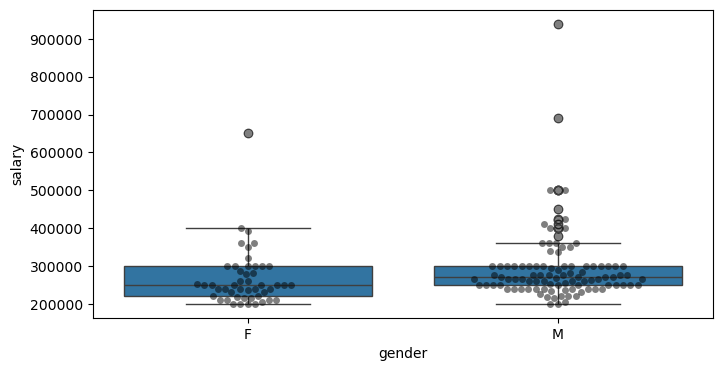

In [14]:
explore(df,"salary", "gender")

Checking normality with Shapiro-Wilk
                W          pval  normal
ssc_b                                  
Others   0.858016  1.213075e-06   False
Central  0.577236  1.207360e-13   False
 
Checking homocedasticity
               W      pval  equal_var
levene  0.019846  0.888162       True
 
Checking dependence of y on x (1-way ANOVA)
   Source            SS   DF            MS        F    p-unc       np2
0   ssc_b  3.939234e+07    1  3.939234e+07  0.00448  0.94673  0.000031
1  Within  1.283902e+12  146  8.793850e+09      NaN      NaN       NaN
p-value=0.946730


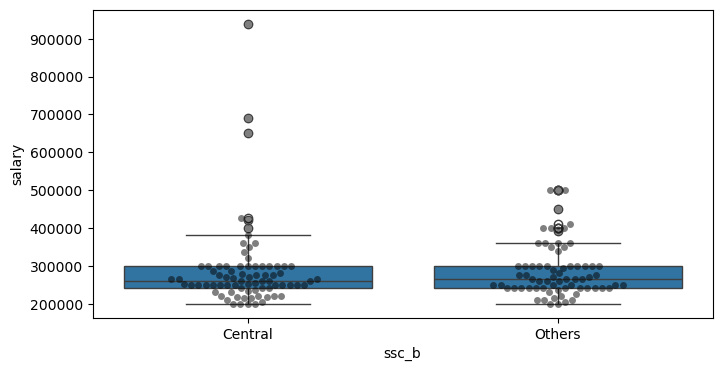

In [15]:
explore(df,"salary","ssc_b")

Checking normality with Shapiro-Wilk
                W          pval  normal
hsc_b                                  
Others   0.814529  2.474884e-09   False
Central  0.547159  5.372872e-12   False
 
Checking homocedasticity
               W      pval  equal_var
levene  0.030993  0.860499       True
 
Checking dependence of y on x (1-way ANOVA)
   Source            SS   DF            MS         F     p-unc       np2
0   hsc_b  7.317543e+07    1  7.317543e+07  0.008321  0.927441  0.000057
1  Within  1.283868e+12  146  8.793618e+09       NaN       NaN       NaN
p-value=0.927441


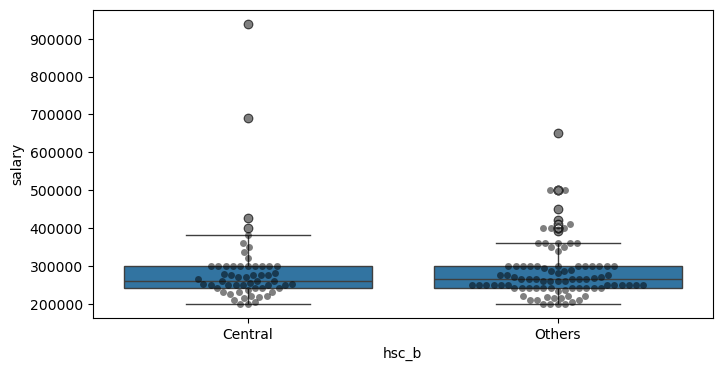

In [16]:
explore(df,"salary", "hsc_b")

Checking normality with Shapiro-Wilk
                 W          pval  normal
hsc_s                                   
Commerce  0.597196  2.150030e-13   False
Science   0.782921  2.987806e-08   False
Arts      0.718533  9.634771e-03   False
 
Checking homocedasticity
               W      pval  equal_var
levene  0.715589  0.490622       True
 
Checking dependence of y on x (1-way ANOVA)
   Source            SS   DF            MS         F     p-unc       np2
0   hsc_s  1.152589e+10    2  5.762947e+09  0.656725  0.520082  0.008977
1  Within  1.272416e+12  145  8.775280e+09       NaN       NaN       NaN
p-value=0.520082


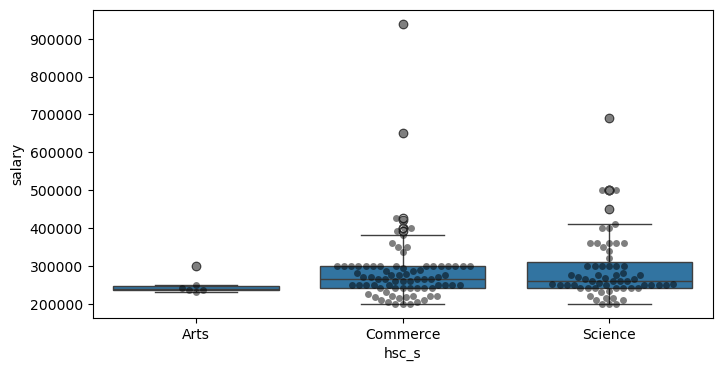

In [17]:
explore(df,"salary", "hsc_s")

Checking normality with Shapiro-Wilk
                  W          pval  normal
degree_t                                 
Sci&Tech   0.817419  1.301934e-05   False
Comm&Mgmt  0.588244  1.805427e-15   False
Others     0.836220  1.547425e-01    True
 
Checking homocedasticity
               W      pval  equal_var
levene  1.111041  0.332002       True
 
Checking dependence of y on x (1-way ANOVA)
     Source            SS   DF            MS         F     p-unc       np2
0  degree_t  3.821663e+10    2  1.910831e+10  2.224171  0.111834  0.029765
1    Within  1.245725e+12  145  8.591206e+09       NaN       NaN       NaN
p-value=0.111834


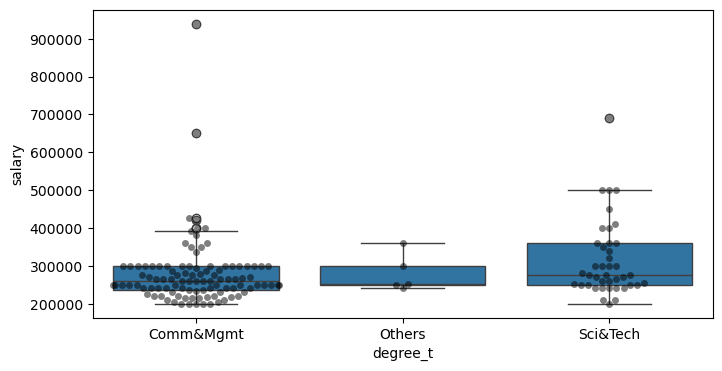

In [18]:
explore(df,"salary", "degree_t")

Checking normality with Shapiro-Wilk
               W          pval  normal
workex                                
No      0.873571  6.636757e-07   False
Yes     0.631419  2.094729e-11   False
 
Checking homocedasticity
               W      pval  equal_var
levene  2.295465  0.131914       True
 
Checking dependence of y on x (1-way ANOVA)
   Source            SS   DF            MS         F     p-unc       np2
0  workex  2.406999e+10    1  2.406999e+10  2.789347  0.097035  0.018747
1  Within  1.259871e+12  146  8.629256e+09       NaN       NaN       NaN
p-value=0.097035


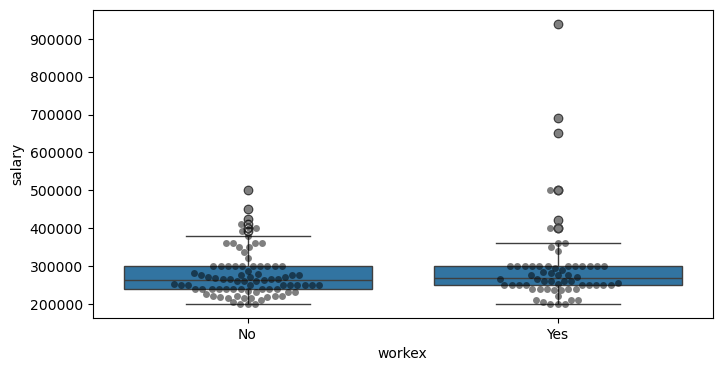

In [19]:
explore(df,"salary", "workex")

## ANOVA

We want to determine if there is a relationship between any of the discrete variables and the salary. ANOVA is a technique of the form y=f(X) where y is continuous and X is discrete.

We have seen above that, if any, there is a relationship with gender, work experience and degree_t. Let us try with the last two.

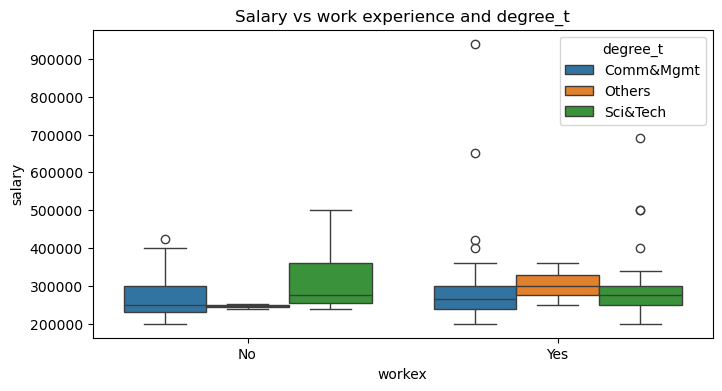

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.set_title('Salary vs work experience and degree_t')
sns.boxplot(x="workex", y="salary", hue='degree_t', data=df, ax=ax);

In [21]:
print('Mean salary and its standard deviation by work experience and degree')
df.groupby(['workex', 'degree_t'],observed=True)['salary'].agg(['mean', 'std'])

Mean salary and its standard deviation by work experience and degree


mean            std
workex degree_t                               
No     Comm&Mgmt  266015.873016   50559.926776
       Others     246000.000000    8485.281374
       Sci&Tech   319000.000000   79516.595053
Yes    Comm&Mgmt  299000.000000  130836.780600
       Others     303333.333333   55075.705473
       Sci&Tech   310818.181818  116691.549604

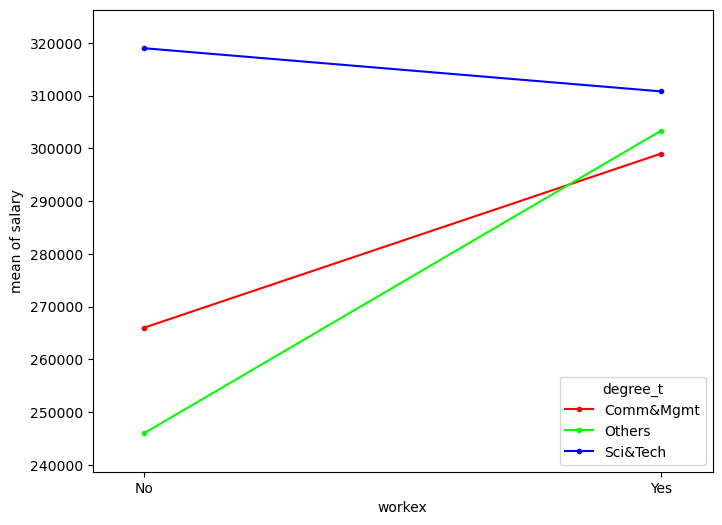

In [22]:
# Let us explore interactions
from statsmodels.graphics.factorplots import interaction_plot
fig, ax = plt.subplots(figsize=(8, 6))
fig = interaction_plot(
    x        = df.workex.astype('object'),
    trace    = df.degree_t.astype('object'),
    response = df.salary,
    ax       = ax,
)

So there is an interaction between work experience and degree.

In [23]:
# Two-way ANOVA
# ==============================================================================
pg.anova(
    data     = df,
    dv       = 'salary',
    between  = ['workex', 'degree_t'],
    detailed = True
).round(4)

,Source,SS,DF,MS,F,p-unc,np2
0,workex,1.714232e+10,1.0,1.714232e+10,2.0036,0.1591,0.0139
1,degree_t,3.128896e+10,2.0,1.564448e+10,1.8286,0.1644,0.0251
2,workex * degree_t,1.369156e+10,2.0,6.845778e+09,0.8002,0.4513,0.0111
3,Residual,1.214891e+12,142.0,8.555570e+09,NaN,NaN,NaN


In [24]:
# Let us try now between gender and work experience
pg.anova(
    data     = df,
    dv       = 'salary',
    between  = ['workex', 'gender'],
    detailed = True
).round(4)

,Source,SS,DF,MS,F,p-unc,np2
0,workex,1.992013e+10,1.0,1.992013e+10,2.3297,0.1291,0.0159
1,gender,2.827346e+10,1.0,2.827346e+10,3.3067,0.0711,0.0224
2,workex * gender,3.286407e+08,1.0,3.286407e+08,0.0384,0.8448,0.0003
3,Residual,1.231269e+12,144.0,8.550482e+09,NaN,NaN,NaN


## Regression

In [25]:
import statsmodels.api as sm
y = df["salary"]
X = df[["mba_p", "etest_p"]]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     3.705
Date:                Sun, 04 Aug 2024   Prob (F-statistic):             0.0270
Time:                        21:56:37   Log-Likelihood:                -1899.7
No. Observations:                 148   AIC:                             3805.
Df Residuals:                     145   BIC:                             3814.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.448e+04   8.29e+04      1.019      0.310   -7.94e+04    2.48e+05
mba_p       2148.3145   1341.754      1.601      0.112    -503.608    4800.237
etest_p      952.1239    575.094      1.656      0.100    -184.527    2088.775
==============================================================================
Omnibus:                      144.632   Durbin-Watson:                   2.165
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2460.436
Skew:                           3.552   Prob(JB):                         0.00
Kurtosis:                      21.669   Cond. No.                     1.07e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""